# Import input data and unpack experimental metadata

In [2]:
import pandas
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import umap
from scipy.stats import zscore
import hdbscan
import seaborn
import math
from sklearn.impute import KNNImputer

In [3]:
writebatch='20211107'
input_df = pandas.read_excel('66T local input and whole brain input.xlsx',
                             sheet_name="Total",header=0,index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
input_df = input_df.iloc[0:4,3:-7]
input_df.head()

,%Cortex,%NAcMed,%NAcLat,%NAcCore,%DStr,%VP,%PO,%Septum,%BNST,%EAM,...,VTA IF,VTA PBP,VTA PN,VTg,IC,SC,PAG,Pretectal,PSth,InC
whole brain,,,,,,,,,,,,,,,,,,,,,
1,702.0,705.0,756.0,711.0,921,1365.0,693.0,45.0,138.0,978,...,197.0,457.0,494.0,48.0,0.0,813.0,627.0,447.0,456.0,417.0
2,183.0,609.0,60.0,249.0,159,654.0,330.0,69.0,189.0,312,...,399.0,1596.0,819.0,81.0,3.0,21.0,177.0,69.0,210.0,90.0
3,762.0,1560.0,480.0,990.0,1692,1440.0,870.0,285.0,438.0,639,...,317.0,1171.0,1078.0,90.0,3.0,648.0,804.0,186.0,198.0,573.0
4,513.0,381.0,366.0,195.0,813,555.0,39.0,33.0,297.0,567,...,70.0,1248.0,378.0,45.0,6.0,51.0,351.0,582.0,252.0,360.0


In [5]:
cols= list(input_df.columns)

In [6]:
for i,c in enumerate(cols):
    cols[i]=c.lstrip("%")

In [7]:
input_fraction_df = input_df.divide(input_df.sum(axis=1),axis=0)

In [8]:
input_fraction_df.head()

,%Cortex,%NAcMed,%NAcLat,%NAcCore,%DStr,%VP,%PO,%Septum,%BNST,%EAM,...,VTA IF,VTA PBP,VTA PN,VTg,IC,SC,PAG,Pretectal,PSth,InC
whole brain,,,,,,,,,,,,,,,,,,,,,
1,0.024983,0.025090,0.026905,0.025303,0.032777,0.048578,0.024663,0.001601,0.004911,0.034806,...,0.007011,0.016264,0.017581,0.001708,0.000000,0.028933,0.022314,0.015908,0.016228,0.014840
2,0.013274,0.044175,0.004352,0.018062,0.011533,0.047439,0.023937,0.005005,0.013710,0.022632,...,0.028942,0.115770,0.059408,0.005876,0.000218,0.001523,0.012839,0.005005,0.015233,0.006528
3,0.022565,0.046196,0.014214,0.029317,0.050105,0.042643,0.025763,0.008440,0.012970,0.018923,...,0.009387,0.034677,0.031923,0.002665,0.000089,0.019189,0.023809,0.005508,0.005863,0.016968
4,0.030134,0.022380,0.021499,0.011454,0.047756,0.032601,0.002291,0.001938,0.017446,0.033306,...,0.004112,0.073308,0.022204,0.002643,0.000352,0.002996,0.020618,0.034187,0.014803,0.021147


In [9]:
scaled_features = input_fraction_df.to_numpy(dtype="float")

# Look at Inputs with Similar Changes in Connectivity Across Samples

In [10]:
scaled_features_t=scaled_features.transpose()

z_scaled_features_t = zscore(scaled_features_t,axis=1)

allembedding=umap.UMAP(n_neighbors=5,min_dist=0.5,metric='euclidean').fit_transform(z_scaled_features_t)

In [16]:
allclusterer=hdbscan.HDBSCAN(min_cluster_size=2)

allclusterer.fit(allembedding)

color_palette = seaborn.color_palette('hls', (numpy.max(allclusterer.labels_+1)))
cluster_colors = [color_palette[x] if x>= 0
                  else (0.5, 0.5, 0.5)
                  for x in allclusterer.labels_]
cluster_member_colors = [seaborn.desaturate(x, p) for x, p in
                        zip(cluster_colors, allclusterer.probabilities_)]
cluster_member_colors_hex=['#%02x%02x%02x' %tuple(int(c*256) for c in l) for l in cluster_member_colors]
fig=go.Figure(data=go.Scatter(
    y=allembedding[:,1],
    x=allembedding[:,0],
    mode='markers+text',
    marker_color=cluster_member_colors_hex,
    text=cols,
    textposition = "bottom center",
    hoverinfo='text'
    ))
fig.update_layout(
    width=800,
    height=800,
    xaxis_title='UMAP 1D',
    yaxis_title='UMAP 2D',
    title={
        'text': "VTA Input Connectivity Similarities - UMAP",
        'x': 0.5
    },
    xaxis={
        'showline':True,
        'showgrid':False, 
        'ticks':'outside',
        'mirror':True,
        'zeroline':False
    },
    yaxis={
        'showline':True,
        'showgrid':False, 
        'ticks':'outside',
        'mirror':True,
        'zeroline':False
    }
)

In [17]:
plotly.io.write_html(fig, file='figures/umap.scaled.66T.regions.'+writebatch+'.html')

<IPython.core.display.Javascript object>


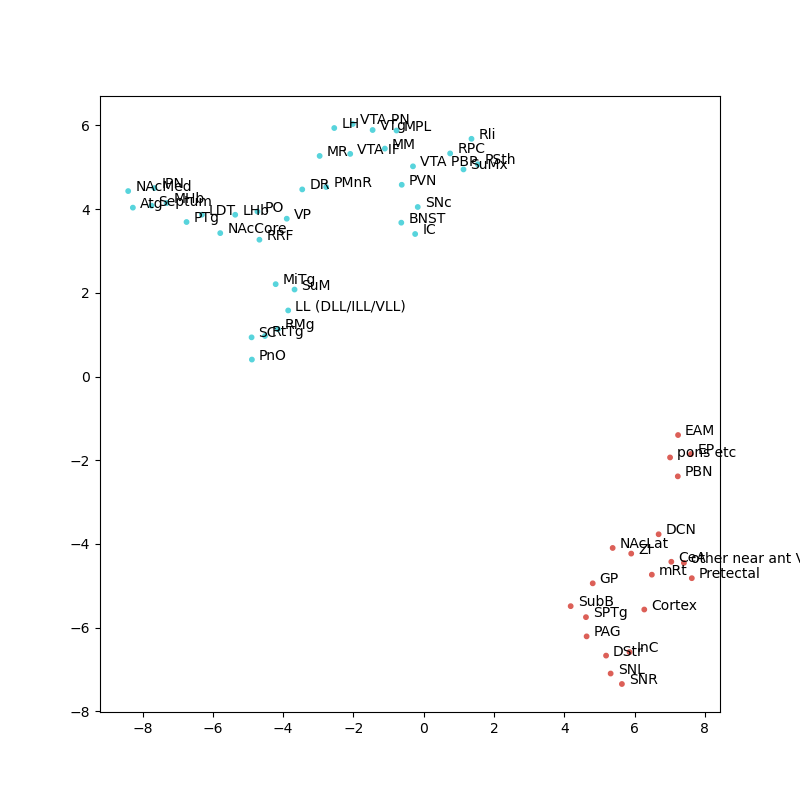

In [18]:
fig, ax = plt.subplots(1,1)
fig.set_figheight(8)
fig.set_figwidth(8)

ax.scatter(allembedding[:,0],allembedding[:,1],s=10, c=cluster_member_colors_hex)
#ax.set_xlim((-13.5,12.5))

for i in range(len(cols)):
    ax.annotate(cols[i], (allembedding[i,0]+0.2, allembedding[i,1]))


fig.savefig('figures/allen.shuffled.region-umap.scaled.'+writebatch+'.png')
fig.savefig('figures/allen.shuffled.region-umap.scaled.'+writebatch+'.svg')

# N UMAP heatmaps

In [19]:
N = 20
umap_distances = numpy.zeros((len(cols),len(cols),N,))
for n in range(0,N):
    embedding=umap.UMAP(n_neighbors=5,min_dist=0.5,metric='euclidean').fit_transform(z_scaled_features_t)
    for r1 in range(0,len(cols)):
        for r2 in range(0,len(cols)):
            d = numpy.sum(numpy.abs(embedding[r1]-embedding[r2]))**(0.5)
            umap_distances[r1,r2,n]=d
    max_distance = numpy.max(umap_distances[:,:,n])
    umap_distances[:,:,n] = umap_distances[:,:,n]/max_distance
umap_distances_means = numpy.mean(umap_distances,axis=2)

<IPython.core.display.Javascript object>


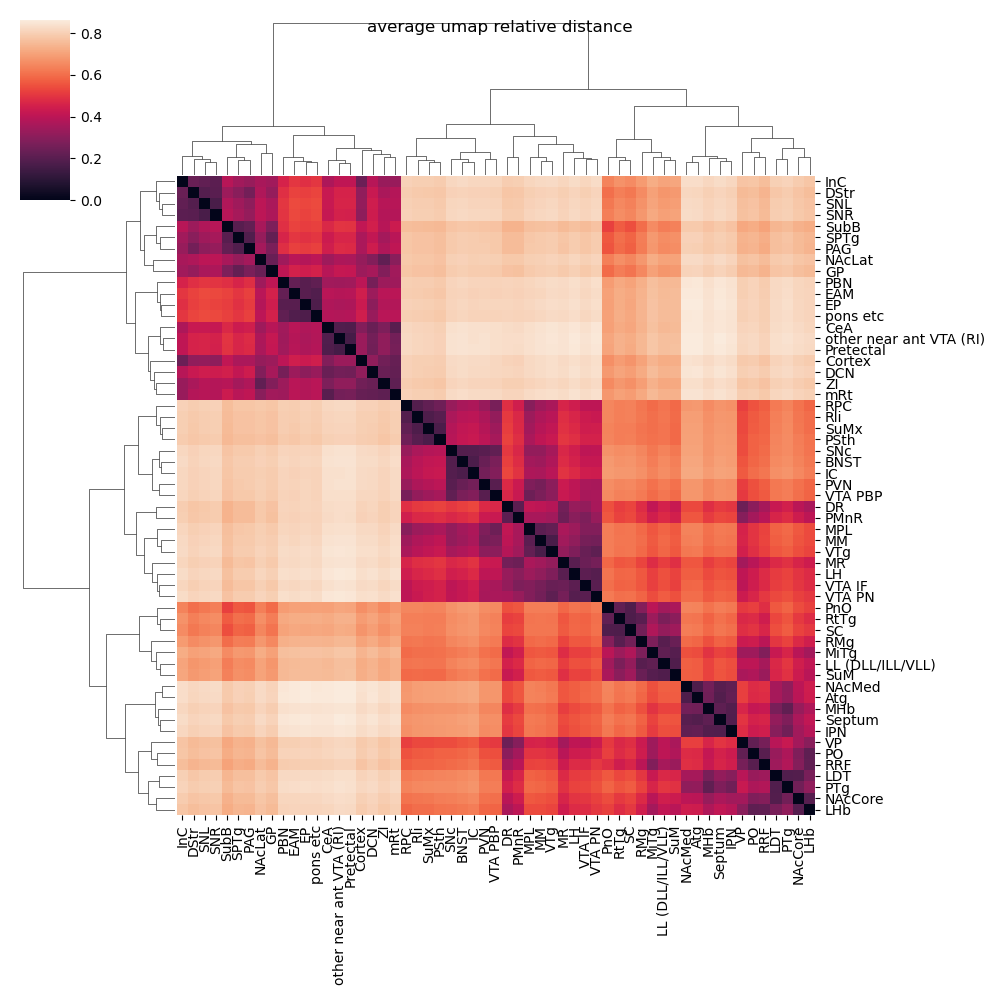

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:625: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [20]:
umap_distances_means_df = pandas.DataFrame(umap_distances_means,index=cols,columns=cols)
cm = seaborn.clustermap(umap_distances_means_df,yticklabels=True,xticklabels=True)
cm.fig.suptitle("average umap relative distance")
plt.savefig("figures/66t.Numaps.hierclusters."+writebatch+".png")
plt.savefig("figures/66t.Numaps.hierclusters."+writebatch+".svg")

In [21]:
og_regions = cols[0:22]

In [22]:
region_order = ['Cortex','NAcMed','NAcLat','NAcCore','DStr','GP',
                'PO','Septum','BNST','PVN','LH','LDT','VP','EAM',
                'LHb','MHb','DR','EP','CeA','ZI','PBN','DCN']

In [23]:
region_order = ['PO','Septum','VP','LDT','LHb','EAM','PVN','MHb','DR','BNST','LH',
                'Cortex','GP','NAcMed','NAcCore','NAcLat','DStr','DCN',
                'EP','ZI','CeA','PBN']

In [24]:
for r in og_regions:
    if r in region_order:
        i=1
    else:
        print(r)

In [25]:
corrected_order = []

for r in region_order:
    if r in og_regions:
        corrected_order.append(numpy.where(numpy.array(og_regions)==r)[0][0])
    else:
        print(r)

In [26]:
idx = corrected_order
rearrange = umap_distances_means[idx,:]
rearrange = rearrange[:,idx]
regions = [og_regions[i] for i in idx]

In [27]:
print(rearrange.shape)
print(len(regions))

(22, 22)
22


<IPython.core.display.Javascript object>


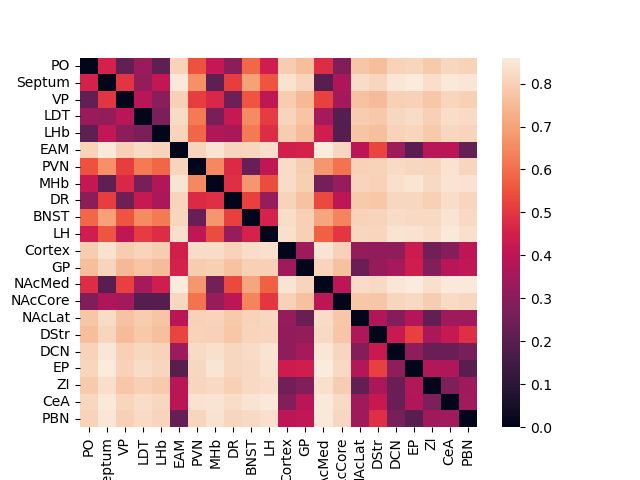

In [28]:
plt.figure()
seaborn.heatmap(rearrange,xticklabels=regions,yticklabels=regions)
plt.savefig("figures/66t.Numaps.orderedheatmap."+writebatch+".png")
plt.savefig("figures/66t.Numaps.orderedheatmap."+writebatch+".svg")

# scramble

In [29]:
def disarrange(a, axis=-1):
    """
    Shuffle `a` in-place along the given axis.

    Apply numpy.random.shuffle to the given axis of `a`.
    Each one-dimensional slice is shuffled independently.
    """
    b = a.swapaxes(axis, -1)
    # Shuffle `b` in-place along the last axis.  `b` is a view of `a`,
    # so `a` is shuffled in place, too.
    shp = b.shape[:-1]
    for ndx in numpy.ndindex(shp):
        numpy.random.shuffle(b[ndx])
    return

In [30]:
shuffle = z_scaled_features_t.copy()
disarrange(shuffle, axis=1)
shuffle.sum(axis=1)

array([-1.11022302e-15,  0.00000000e+00, -3.33066907e-16, -1.27675648e-15,
       -2.22044605e-16,  1.11022302e-15,  5.55111512e-16,  7.77156117e-16,
       -1.08246745e-15, -6.66133815e-16, -8.88178420e-16, -8.27463098e-16,
        9.99200722e-16, -1.22124533e-15,  0.00000000e+00,  0.00000000e+00,
       -1.33226763e-15,  4.44089210e-16, -1.60982339e-15, -1.66533454e-15,
       -3.33066907e-16,  2.22044605e-16, -4.44089210e-16,  6.66133815e-16,
        2.22044605e-16, -4.99600361e-16, -4.44089210e-16,  2.22044605e-16,
        2.22044605e-16,  3.05311332e-16, -6.76542156e-17, -8.88178420e-16,
       -6.66133815e-16, -6.24500451e-17,  1.11022302e-15,  1.05471187e-15,
        9.92261828e-16,  4.44089210e-16, -2.10942375e-15,  1.11022302e-16,
        1.99840144e-15, -8.88178420e-16,  6.66133815e-16, -2.22044605e-16,
       -2.22044605e-16,  2.22044605e-16,  0.00000000e+00, -1.11022302e-16,
        4.44089210e-16,  2.08166817e-16, -1.11022302e-16,  6.66133815e-16,
       -1.11022302e-16,  

In [31]:
N = 20
shuffle_umap_distances = numpy.zeros((len(cols),len(cols),N,))
for n in range(0,N):
    embedding=umap.UMAP(n_neighbors=5,min_dist=0.5,metric='euclidean').fit_transform(shuffle)
    for r1 in range(0,len(cols)):
        for r2 in range(0,len(cols)):
            d = numpy.sum(numpy.abs(embedding[r1]-embedding[r2]))**(0.5)
            shuffle_umap_distances[r1,r2,n]=d
    max_distance = numpy.max(shuffle_umap_distances[:,:,n])
    shuffle_umap_distances[:,:,n] = shuffle_umap_distances[:,:,n]/max_distance
shuffle_umap_distances_means = numpy.mean(umap_distances,axis=2)

<IPython.core.display.Javascript object>


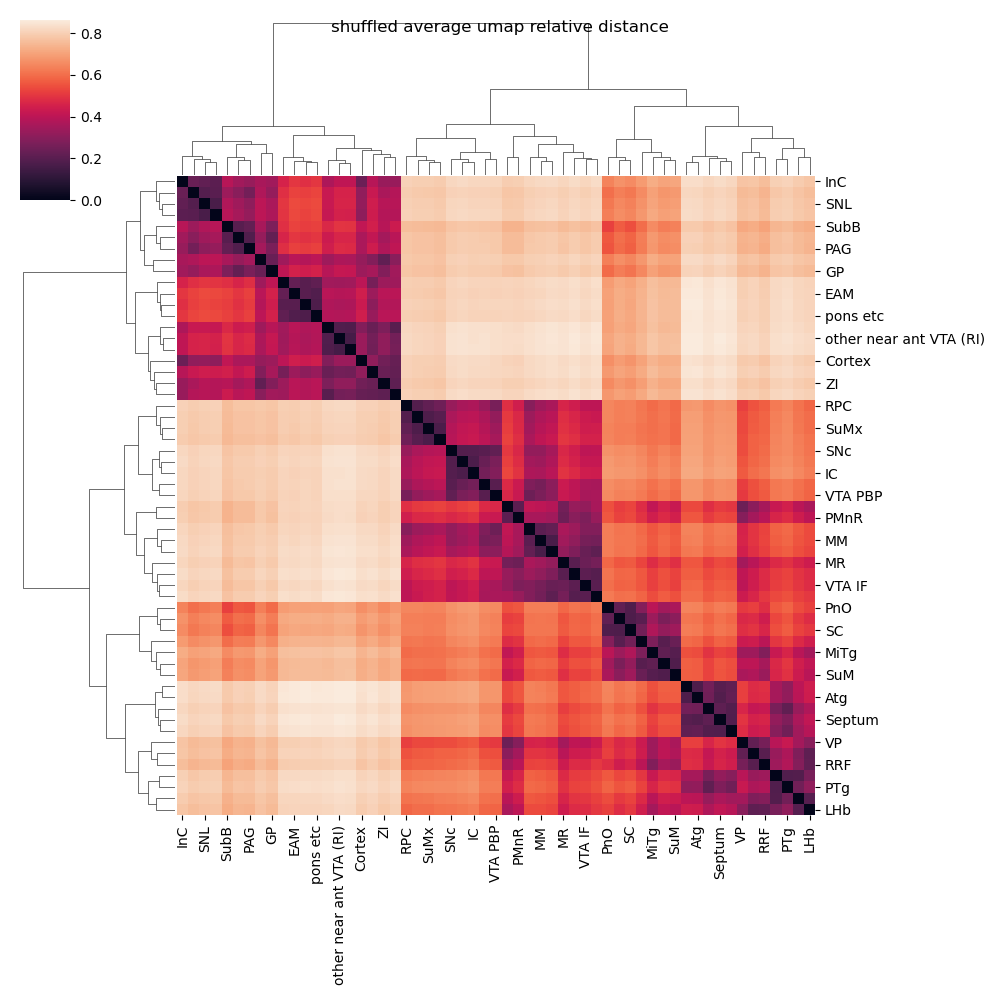

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:625: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [32]:
shuffle_umap_distances_means_df = pandas.DataFrame(shuffle_umap_distances_means,index=cols,columns=cols)
cm = seaborn.clustermap(shuffle_umap_distances_means_df)
cm.fig.suptitle("shuffled average umap relative distance")
plt.savefig("figures/66t.shuffled.Numaps.hierclusters."+writebatch+".png")
plt.savefig("figures/66t.shuffled.Numaps.hierclusters."+writebatch+".svg")

In [33]:
region_order = ['Cortex','NAcMed','NAcLat','NAcCore','DStr','GP',
                'PO','Septum','BNST','PVN','LH','LDT','VP','EAM',
                'LHb','MHb','DR','EP','CeA','ZI','PBN','DCN']

In [34]:
region_order = ['PO','Septum','VP','LDT','LHb','EAM','PVN','MHb','DR','BNST','LH',
                'Cortex','GP','NAcMed','NAcCore','NAcLat','DStr','DCN',
                'EP','ZI','CeA','PBN']

In [35]:
corrected_order = []

for r in region_order:
    if r in og_regions:
        corrected_order.append(numpy.where(numpy.array(og_regions)==r)[0][0])
    else:
        print(r)

In [36]:
idx = corrected_order
rearrange = shuffle_umap_distances_means[idx,:]
rearrange = rearrange[:,idx]
regions = [og_regions[i] for i in idx]

<IPython.core.display.Javascript object>


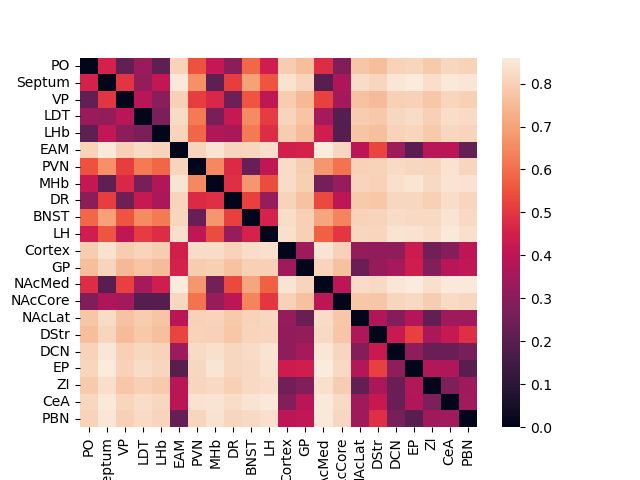

In [37]:
plt.figure()
seaborn.heatmap(rearrange,xticklabels=regions,yticklabels=regions)
plt.savefig("figures/66t.shuffled.Numaps.orderedheatmap."+writebatch+".png")
plt.savefig("figures/66t.shuffled.Numaps.orderedheatmap."+writebatch+".svg")

# try imputation

In [38]:
input_df.columns = cols

In [40]:
all_input_df = pandas.read_excel('76 brain input tracing dataset.xlsx',header=1)
all_input_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning:

Unknown extension is not supported and will be removed



,Experimental condition,Cre line:,Output site:,% starter cells that are TH+,total rabies-labeled input cells,Cortex,NAcMed,NAcLat,NAcCore,DStr,...,CeA,LH,ZI,DR,LDT,PBN,DCN,XCoordCOM,YCoordCOM,ZCoordCOM
0,cTRIO DAT-CreBLA 3,DAT-Cre,Amygdala,100,1727,1.563405,1.215981,2.779386,1.563405,5.037638,...,7.122177,5.037638,4.863926,25.883034,0.579039,12.680950,1.215981,1140.648,1228.338000,4.661972
1,cTRIO DAT-CreBLA 4,DAT-Cre,Amygdala,100,244,2.459016,0.000000,2.459016,0.000000,3.688525,...,4.918033,15.983607,3.688525,29.508197,0.409836,8.606557,0.409836,1202.733,1113.200000,7.000000
2,cTRIO DAT-CreBLA 5,DAT-Cre,Amygdala,88,614,0.488599,0.000000,0.000000,0.488599,0.000000,...,8.794788,7.328990,9.283388,23.941368,0.977199,11.726384,0.325733,1157.273,1219.727000,5.090909
3,cTRIO DAT-CreBLA 6,DAT-Cre,Amygdala,92,604,4.470199,6.953642,2.980132,1.490066,1.986755,...,2.980132,8.443709,12.913907,49.668874,0.827815,3.973510,0.993377,1227.500,1163.666667,5.666667
4,cTRIO DAT-CreNAcLat 1,DAT-Cre,NAcLat,95,36581,8.783248,6.437768,5.330636,8.865258,11.030316,...,2.156857,6.355758,4.141494,8.291189,0.451054,5.486455,0.923977,1120.353,1221.481000,5.358289


In [41]:
main_regions = list(input_df.columns)[0:22]

In [42]:
all_regions = list(input_df.columns)

In [43]:
fraction_df = input_df[all_regions].divide(input_df[main_regions].sum(axis=1)
                              /100,axis=0)

fraction_df['Experimental condition'] = ['(whole) DAT-Cre 66T ' + str(i+1) for i in range(4)]
fraction_df['Cre line:'] = ['DAT-Cre']*4

full_inputs_df = pandas.merge(all_input_df,fraction_df,how='outer')

full_inputs_df['is 66T'] = [True if '66T' in c else False for c in full_inputs_df['Experimental condition']]

full_inputs_counts = full_inputs_df[all_regions].values

In [44]:
imputer = KNNImputer(n_neighbors = 10)
imputed_counts = imputer.fit_transform(full_inputs_counts)

scaled_features = preprocessing.scale(imputed_counts)

allembedding=umap.UMAP(n_neighbors=5,min_dist=0.5,metric='euclidean').fit_transform(scaled_features)

conds = full_inputs_df['is 66T'].unique()

In [45]:
cmap=plt.get_cmap('rainbow')
colors = cmap(numpy.linspace(0, 1, len(conds)))
colors_hex=[matplotlib.colors.rgb2hex(l) for l in colors]
color={}
for i,cond in enumerate(conds):
    color[cond]=colors_hex[i]
    
color=full_inputs_df['is 66T'].map(color)
    
fig=go.Figure(data=go.Scatter(
    y=allembedding[:,1],
    x=allembedding[:,0],
    mode='markers',
    marker_color=color,
    text=full_inputs_df['Experimental condition'],
    textposition = "bottom center",
    hoverinfo='text'
    ))
fig.update_layout(
    width=800,
    height=800,
    xaxis_title='UMAP 1D',
    yaxis_title='UMAP 2D',
    title={
        'text': "66T Regions: Brain UMAP",
        'x': 0.5
    },
    xaxis={
        'showline':True,
        'showgrid':False, 
        'ticks':'outside',
        'mirror':True,
        'zeroline':False
    },
    yaxis={
        'showline':True,
        'showgrid':False, 
        'ticks':'outside',
        'mirror':True,
        'zeroline':False
    }
)

In [46]:
plotly.io.write_html(fig, file='figures/umap.scaled.66T.'+writebatch+'.html')

In [47]:
conds = full_inputs_df['Output site:'].unique()
cmap=plt.get_cmap('rainbow')
colors = cmap(numpy.linspace(0, 1, len(conds)))
colors_hex=[matplotlib.colors.rgb2hex(l) for l in colors]
color={}
for i,cond in enumerate(conds):
    color[cond]=colors_hex[i]
    
color=full_inputs_df['Output site:'].map(color)
    
fig=go.Figure(data=go.Scatter(
    y=allembedding[:,1],
    x=allembedding[:,0],
    mode='markers',
    marker_color=color,
    text=full_inputs_df['Experimental condition'],
    textposition = "bottom center",
    hoverinfo='text'
    ))
fig.update_layout(
    width=800,
    height=800,
    xaxis_title='UMAP 1D',
    yaxis_title='UMAP 2D',
    title={
        'text': "66T Regions: Brain UMAP",
        'x': 0.5
    },
    xaxis={
        'showline':True,
        'showgrid':False, 
        'ticks':'outside',
        'mirror':True,
        'zeroline':False
    },
    yaxis={
        'showline':True,
        'showgrid':False, 
        'ticks':'outside',
        'mirror':True,
        'zeroline':False
    }
)

In [48]:
plotly.io.write_html(fig, file='figures/umap.scaled.66T.projection.'+writebatch+'.html')

In [49]:
scaled_features_t=scaled_features.transpose()

z_scaled_features_t = zscore(scaled_features_t,axis=1)

allembedding=umap.UMAP(n_neighbors=5,min_dist=0.5,metric='euclidean').fit_transform(z_scaled_features_t)

In [50]:
allclusterer=hdbscan.HDBSCAN(min_cluster_size=2)

allclusterer.fit(allembedding)

color_palette = seaborn.color_palette('hls', (numpy.max(allclusterer.labels_+1)))
cluster_colors = [color_palette[x] if x>= 0
                  else (0.5, 0.5, 0.5)
                  for x in allclusterer.labels_]
cluster_member_colors = [seaborn.desaturate(x, p) for x, p in
                        zip(cluster_colors, allclusterer.probabilities_)]
cluster_member_colors_hex=['#%02x%02x%02x' %tuple(int(c*256) for c in l) for l in cluster_member_colors]
fig=go.Figure(data=go.Scatter(
    y=allembedding[:,1],
    x=allembedding[:,0],
    mode='markers+text',
    marker_color=cluster_member_colors_hex,
    text=cols,
    textposition = "bottom center",
    hoverinfo='text'
    ))
fig.update_layout(
    width=800,
    height=800,
    xaxis_title='UMAP 1D',
    yaxis_title='UMAP 2D',
    title={
        'text': "VTA Input Connectivity Similarities - UMAP",
        'x': 0.5
    },
    xaxis={
        'showline':True,
        'showgrid':False, 
        'ticks':'outside',
        'mirror':True,
        'zeroline':False
    },
    yaxis={
        'showline':True,
        'showgrid':False, 
        'ticks':'outside',
        'mirror':True,
        'zeroline':False
    }
)

In [51]:
plotly.io.write_html(fig, file='figures/umap.regions.scaled.66T.'+writebatch+'.html')